In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,precision_recall_fscore_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, MaxPooling2D, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import cv2
import PIL.Image as Image
import os
import random
import glob
from scipy.spatial import distance
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

ImportError: DLL load failed while importing cv2: The specified module could not be found.

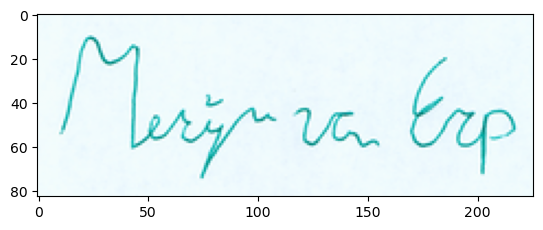

In [56]:
#dataset_path = '/content/drive/MyDrive/ML-Datasets-colab/Dataset_sign'
dataset_path = './DataSet/Dataset_Signature_Final'
#img = plt.imread('/content/drive/MyDrive/ML-Datasets-colab/sample_Signature/forged/NFI-00301001.png')
img = plt.imread('./DataSet/Dataset_Signature_Final/Dataset/dataset1/forge/02100001.png')
plt.imshow(img)

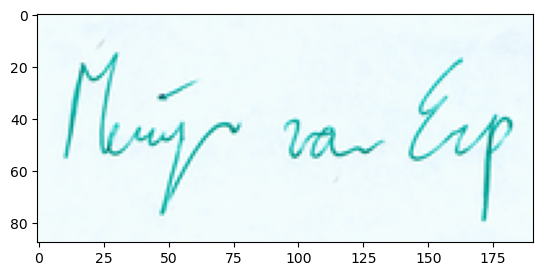

In [57]:
#img1 = plt.imread('/content/drive/MyDrive/ML-Datasets-colab/sample_Signature/genuine/NFI-00101001.png')
img1=plt.imread('./DataSet/Dataset_Signature_Final/Dataset/dataset1/real/00100001.png')
plt.imshow(img1)

In [48]:
IMAGE_SHAPE = (224,224)
real_signs = [
       glob.glob('./DataSet/Dataset_Signature_Final/Dataset/dataset1/real/*.*'),
       glob.glob('./DataSet/Dataset_Signature_Final/Dataset/dataset2/real/*.*'),
       glob.glob('./DataSet/Dataset_Signature_Final/Dataset/dataset3/real/*.*'),
       glob.glob('./DataSet/Dataset_Signature_Final/Dataset/dataset4/real1/*.*')]

forged_signs = [
        glob.glob('./DataSet/Dataset_Signature_Final/Dataset/dataset1/forge/*.*'),
        glob.glob('./DataSet/Dataset_Signature_Final/Dataset/dataset2/forge/*.*'),
        glob.glob('./DataSet/Dataset_Signature_Final/Dataset/dataset3/forge/*.*'),
        glob.glob('./DataSet/Dataset_Signature_Final/Dataset/dataset4/forge/*.*')
]

In [24]:
import sys
!conda install --yes --prefix {sys.prefix} opencv

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2




In [26]:
#import cv2

ImportError: DLL load failed while importing cv2: The specified module could not be found.

In [49]:
training_data=[]
training_labels=[]
testing_data = []
train_paths=[]
testing_labels=[]
test_paths=[]
for data in range(len(real_signs)):
   for it in real_signs[data]:
       image = Image.open(it)
       if image.mode != 'RGB':
           image = image.convert('RGB')
       resized_img = image.resize(IMAGE_SHAPE)
       '''
        image = cv2.imread(it)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        resized_img = cv2.resize(image,IMAGE_SHAPE)'''
       if data==3:
          test_paths.append(it)
          testing_data.append(resized_img)
          testing_labels.append(0)  #0 stands for real signs
       else:
          train_paths.append(it)
          training_data.append(resized_img)
          training_labels.append(0)
for data in range(len(forged_signs)):
    for it in forged_signs[data]:
        '''image= cv2.imread(it)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        resized_img = cv2.resize(image,IMAGE_SHAPE)'''
        image=Image.open(it)
        if image.mode != 'RGB':
           image = image.convert('RGB')
        resized_img = image.resize(IMAGE_SHAPE)
        if data==3:
          testing_data.append(resized_img)
          test_paths.append(it)
          testing_labels.append(1)  #1 stands for forged signs
        else:
          training_data.append(resized_img)
          train_paths.append(it)
          training_labels.append(1)


In [50]:
test_paths[:4]

['./DataSet/Dataset_Signature_Final/Dataset/dataset4/real1\\00201002.png',
 './DataSet/Dataset_Signature_Final/Dataset/dataset4/real1\\00202002.png',
 './DataSet/Dataset_Signature_Final/Dataset/dataset4/real1\\00203002.png',
 './DataSet/Dataset_Signature_Final/Dataset/dataset4/real1\\00204002.png']

In [60]:
training_data = np.array(training_data)
testing_data = np.array(testing_data)
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [61]:
training_data = training_data/255.0
testing_data = testing_data/255.0
num_train = sum([len(x) for x in training_data])
num_test = sum([len(x) for x in testing_data])
print(f"Training data length: {num_train}")
print(f"Testing data length: {num_test}")

Training data length: 120960
Testing data length: 40320


In [62]:
def load_images(file_list):
    images = []
    for files in file_list:
        for file in files:
            img = Image.open(file)
            #img = cv2.imread(file)
            images.append(img)
    return images

In [63]:
gen_imgs = load_images(real_signs)
forg_imgs = load_images(forged_signs)
len(forg_imgs)

360

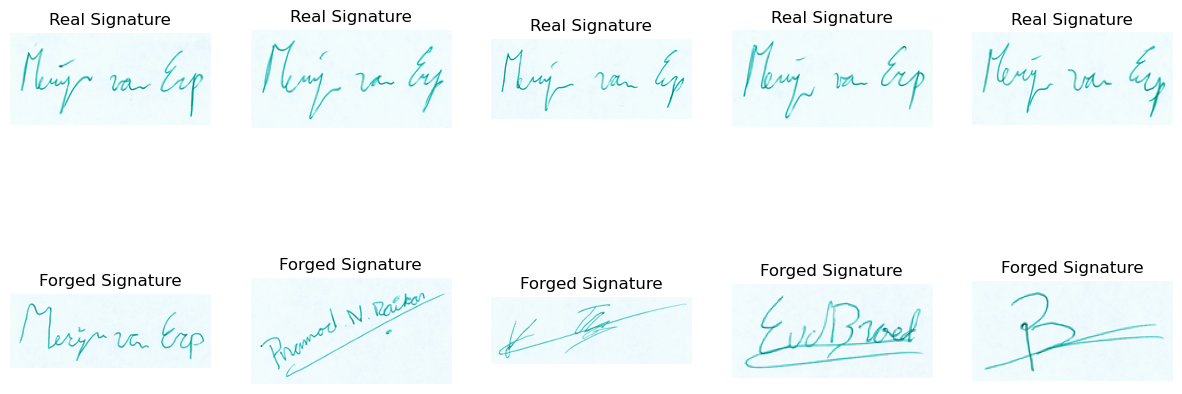

In [67]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    real_img = gen_imgs[i]
    rgb_real_img = real_img.convert('RGB')
    axs[0, i].imshow(rgb_real_img)
    #axs[0, i].imshow(cv2.cvtColor(gen_imgs[i], cv2.COLOR_BGR2RGB))
    axs[0, i].set_title("Real Signature")
    axs[0, i].axis("off")

    real_img = forg_imgs[i]
    rgb_real_img = real_img.convert('RGB')
    axs[1, i].imshow(rgb_real_img)
    #axs[1, i].imshow(cv2.cvtColor(forg_imgs[i], cv2.COLOR_BGR2RGB))
    axs[1, i].set_title("Forged Signature")
    axs[1, i].axis("off")

plt.show()

In [68]:
training_data.shape

(540, 224, 224, 3)

In [69]:
testing_data.shape

(180, 224, 224, 3)

In [70]:
from sklearn.utils import shuffle
training_labels = to_categorical(training_labels)
testing_labels = to_categorical(testing_labels)
training_data,training_labels,train_paths = shuffle(training_data,training_labels,train_paths)
testing_data,testing_labels,test_paths = shuffle(testing_data,testing_labels,test_paths)


In [71]:
model = Sequential()

model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))
#CNN Layer 1
model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

#CNN Layer 2
model.add(Conv2D(64,(3,3),1,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))


#CNN Layer 3
model.add(Conv2D(128,(3,3),1,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

#CNN Layer 4
model.add(Conv2D(64,(3,3),1,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))

#CNN Layer 5
model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.25))



#Flattening the output of Conv
model.add(Flatten())

#Adding Hidden layers along with Dropout
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64,activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(32,activation='relu'))

model.add(Dropout(0.25))


#Output layer
model.add(Dense(2,activation='softmax'))


In [72]:
model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

In [73]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 32)     1

In [74]:
filepath = './model.sav'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath,monitor='val_loss',verbose=1,save_best_only=True,mode='min')
callbacks = [checkpoint]


In [75]:
progress=model.fit(training_data,training_labels,batch_size=8,epochs=50,callbacks=[callbacks],validation_split=0.2)

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 0.8630 - accuracy: 0.4907
Epoch 1: val_loss improved from inf to 0.69589, saving model to .\model.sav


INFO:tensorflow:Assets written to: .\model.sav\assets


INFO:tensorflow:Assets written to: .\model.sav\assets


54/54 [==============================] - 14s 231ms/step - loss: 0.8630 - accuracy: 0.4907 - val_loss: 0.6959 - val_accuracy: 0.4537
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.7603 - accuracy: 0.5185
Epoch 2: val_loss did not improve from 0.69589
54/54 [==============================] - 6s 109ms/step - loss: 0.7603 - accuracy: 0.5185 - val_loss: 0.7133 - val_accuracy: 0.4537
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 0.7138 - accuracy: 0.5347
Epoch 3: val_loss did not improve from 0.69589
54/54 [==============================] - 7s 128ms/step - loss: 0.7138 - accuracy: 0.5347 - val_loss: 0.7152 - val_accuracy: 0.4537
Epoch 4/50
54/54 [==============================] - ETA: 0s - loss: 0.7471 - accuracy: 0.5093
Epoch 4: val_loss did not improve from 0.69589
54/54 [==============================] - 6s 109ms/step - loss: 0.7471 - accuracy: 0.5093 - val_loss: 0.7071 - val_accuracy: 0.4537
Epoch 5/50
54/54 [==============================] - 

INFO:tensorflow:Assets written to: .\model.sav\assets


INFO:tensorflow:Assets written to: .\model.sav\assets


54/54 [==============================] - 11s 212ms/step - loss: 0.7188 - accuracy: 0.5093 - val_loss: 0.6899 - val_accuracy: 0.5463
Epoch 6/50
54/54 [==============================] - ETA: 0s - loss: 0.7102 - accuracy: 0.5347
Epoch 6: val_loss improved from 0.68994 to 0.68893, saving model to .\model.sav


INFO:tensorflow:Assets written to: .\model.sav\assets


INFO:tensorflow:Assets written to: .\model.sav\assets


54/54 [==============================] - 11s 212ms/step - loss: 0.7102 - accuracy: 0.5347 - val_loss: 0.6889 - val_accuracy: 0.5463
Epoch 7/50
54/54 [==============================] - ETA: 0s - loss: 0.7228 - accuracy: 0.5139
Epoch 7: val_loss did not improve from 0.68893
54/54 [==============================] - 7s 129ms/step - loss: 0.7228 - accuracy: 0.5139 - val_loss: 0.7001 - val_accuracy: 0.5463
Epoch 8/50
54/54 [==============================] - ETA: 0s - loss: 0.7082 - accuracy: 0.5116
Epoch 8: val_loss did not improve from 0.68893
54/54 [==============================] - 7s 135ms/step - loss: 0.7082 - accuracy: 0.5116 - val_loss: 0.6993 - val_accuracy: 0.5463
Epoch 9/50
54/54 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.5093
Epoch 9: val_loss did not improve from 0.68893
54/54 [==============================] - 6s 120ms/step - loss: 0.6962 - accuracy: 0.5093 - val_loss: 0.7752 - val_accuracy: 0.5463
Epoch 10/50
54/54 [==============================] -

INFO:tensorflow:Assets written to: .\model.sav\assets


INFO:tensorflow:Assets written to: .\model.sav\assets


54/54 [==============================] - 11s 209ms/step - loss: 0.6906 - accuracy: 0.5648 - val_loss: 0.6889 - val_accuracy: 0.5556
Epoch 20/50
54/54 [==============================] - ETA: 0s - loss: 0.6480 - accuracy: 0.6389
Epoch 20: val_loss improved from 0.68887 to 0.68339, saving model to .\model.sav


INFO:tensorflow:Assets written to: .\model.sav\assets


INFO:tensorflow:Assets written to: .\model.sav\assets


54/54 [==============================] - 11s 208ms/step - loss: 0.6480 - accuracy: 0.6389 - val_loss: 0.6834 - val_accuracy: 0.5093
Epoch 21/50
54/54 [==============================] - ETA: 0s - loss: 0.6457 - accuracy: 0.5995
Epoch 21: val_loss did not improve from 0.68339
54/54 [==============================] - 6s 107ms/step - loss: 0.6457 - accuracy: 0.5995 - val_loss: 0.7842 - val_accuracy: 0.4630
Epoch 22/50
54/54 [==============================] - ETA: 0s - loss: 0.6546 - accuracy: 0.6481
Epoch 22: val_loss did not improve from 0.68339
54/54 [==============================] - 6s 106ms/step - loss: 0.6546 - accuracy: 0.6481 - val_loss: 0.6897 - val_accuracy: 0.5463
Epoch 23/50
54/54 [==============================] - ETA: 0s - loss: 0.6579 - accuracy: 0.6296
Epoch 23: val_loss did not improve from 0.68339
54/54 [==============================] - 6s 108ms/step - loss: 0.6579 - accuracy: 0.6296 - val_loss: 0.6958 - val_accuracy: 0.4537
Epoch 24/50
54/54 [===========================

INFO:tensorflow:Assets written to: .\model.sav\assets


INFO:tensorflow:Assets written to: .\model.sav\assets


54/54 [==============================] - 12s 216ms/step - loss: 0.5525 - accuracy: 0.7292 - val_loss: 0.6715 - val_accuracy: 0.5741
Epoch 26/50
54/54 [==============================] - ETA: 0s - loss: 0.5250 - accuracy: 0.7477
Epoch 26: val_loss did not improve from 0.67153
54/54 [==============================] - 6s 110ms/step - loss: 0.5250 - accuracy: 0.7477 - val_loss: 0.7253 - val_accuracy: 0.5556
Epoch 27/50
54/54 [==============================] - ETA: 0s - loss: 0.5362 - accuracy: 0.7338
Epoch 27: val_loss improved from 0.67153 to 0.65626, saving model to .\model.sav


INFO:tensorflow:Assets written to: .\model.sav\assets


INFO:tensorflow:Assets written to: .\model.sav\assets


54/54 [==============================] - 11s 213ms/step - loss: 0.5362 - accuracy: 0.7338 - val_loss: 0.6563 - val_accuracy: 0.6574
Epoch 28/50
54/54 [==============================] - ETA: 0s - loss: 0.5254 - accuracy: 0.7454
Epoch 28: val_loss did not improve from 0.65626
54/54 [==============================] - 6s 107ms/step - loss: 0.5254 - accuracy: 0.7454 - val_loss: 0.6750 - val_accuracy: 0.5648
Epoch 29/50
54/54 [==============================] - ETA: 0s - loss: 0.4893 - accuracy: 0.7685
Epoch 29: val_loss did not improve from 0.65626
54/54 [==============================] - 6s 108ms/step - loss: 0.4893 - accuracy: 0.7685 - val_loss: 0.6940 - val_accuracy: 0.5463
Epoch 30/50
54/54 [==============================] - ETA: 0s - loss: 0.4374 - accuracy: 0.7986
Epoch 30: val_loss did not improve from 0.65626
54/54 [==============================] - 6s 113ms/step - loss: 0.4374 - accuracy: 0.7986 - val_loss: 0.9207 - val_accuracy: 0.5463
Epoch 31/50
54/54 [===========================

INFO:tensorflow:Assets written to: .\model.sav\assets


INFO:tensorflow:Assets written to: .\model.sav\assets


54/54 [==============================] - 11s 210ms/step - loss: 0.4069 - accuracy: 0.8333 - val_loss: 0.5064 - val_accuracy: 0.7593
Epoch 33/50
54/54 [==============================] - ETA: 0s - loss: 0.3773 - accuracy: 0.8449
Epoch 33: val_loss did not improve from 0.50644
54/54 [==============================] - 6s 114ms/step - loss: 0.3773 - accuracy: 0.8449 - val_loss: 0.6352 - val_accuracy: 0.5833
Epoch 34/50
54/54 [==============================] - ETA: 0s - loss: 0.3394 - accuracy: 0.8565
Epoch 34: val_loss did not improve from 0.50644
54/54 [==============================] - 6s 119ms/step - loss: 0.3394 - accuracy: 0.8565 - val_loss: 0.6617 - val_accuracy: 0.5926
Epoch 35/50
54/54 [==============================] - ETA: 0s - loss: 0.3270 - accuracy: 0.8796
Epoch 35: val_loss did not improve from 0.50644
54/54 [==============================] - 6s 106ms/step - loss: 0.3270 - accuracy: 0.8796 - val_loss: 1.5792 - val_accuracy: 0.4907
Epoch 36/50
54/54 [===========================

INFO:tensorflow:Assets written to: .\model.sav\assets


INFO:tensorflow:Assets written to: .\model.sav\assets


54/54 [==============================] - 12s 220ms/step - loss: 0.2502 - accuracy: 0.8935 - val_loss: 0.4007 - val_accuracy: 0.8056
Epoch 38/50
54/54 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.9051
Epoch 38: val_loss did not improve from 0.40075
54/54 [==============================] - 6s 109ms/step - loss: 0.2529 - accuracy: 0.9051 - val_loss: 1.0627 - val_accuracy: 0.5370
Epoch 39/50
54/54 [==============================] - ETA: 0s - loss: 0.2699 - accuracy: 0.8912
Epoch 39: val_loss did not improve from 0.40075
54/54 [==============================] - 7s 134ms/step - loss: 0.2699 - accuracy: 0.8912 - val_loss: 0.7545 - val_accuracy: 0.5463
Epoch 40/50
54/54 [==============================] - ETA: 0s - loss: 0.3099 - accuracy: 0.8866
Epoch 40: val_loss did not improve from 0.40075
54/54 [==============================] - 6s 109ms/step - loss: 0.3099 - accuracy: 0.8866 - val_loss: 0.6947 - val_accuracy: 0.6204
Epoch 41/50
54/54 [===========================

INFO:tensorflow:Assets written to: .\model.sav\assets


INFO:tensorflow:Assets written to: .\model.sav\assets


54/54 [==============================] - 12s 218ms/step - loss: 0.1715 - accuracy: 0.9259 - val_loss: 0.3348 - val_accuracy: 0.8611
Epoch 50/50
54/54 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.9722
Epoch 50: val_loss did not improve from 0.33479
54/54 [==============================] - 6s 116ms/step - loss: 0.1454 - accuracy: 0.9722 - val_loss: 0.8109 - val_accuracy: 0.6944


In [76]:
model.evaluate(testing_data,testing_labels)

6/6 [==============================] - 1s 90ms/step - loss: 0.9715 - accuracy: 0.6889


[0.9714903831481934, 0.6888889074325562]

In [77]:
pred = model.predict(testing_data)
print(pred[:20])

6/6 [==============================] - 1s 95ms/step
[[7.26247323e-04 9.99273717e-01]
 [8.05490185e-03 9.91945088e-01]
 [3.23916058e-04 9.99676168e-01]
 [7.76823521e-01 2.23176524e-01]
 [8.91812325e-01 1.08187646e-01]
 [8.40134174e-03 9.91598606e-01]
 [9.79898691e-01 2.01013256e-02]
 [6.15559816e-01 3.84440094e-01]
 [5.82608104e-01 4.17391866e-01]
 [3.23279984e-02 9.67671931e-01]
 [7.46225760e-06 9.99992430e-01]
 [9.83490586e-01 1.65093131e-02]
 [9.02510285e-01 9.74896550e-02]
 [4.72312748e-01 5.27687132e-01]
 [8.65692738e-03 9.91343021e-01]
 [3.05904032e-05 9.99969304e-01]
 [9.37321723e-01 6.26782700e-02]
 [1.14671066e-01 8.85329068e-01]
 [9.95373070e-01 4.62694187e-03]
 [5.76946735e-01 4.23053294e-01]]


In [78]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
# Assuming testing_labels is one-hot encoded
encoder = LabelEncoder()
encoded_testing_labels = encoder.fit_transform(testing_labels.argmax(axis=1))

accuracy = accuracy_score(pred.argmax(axis=1), encoded_testing_labels)

In [79]:
print(accuracy)

0.6888888888888889


In [80]:
pred = np.argmax(pred, axis=1)
pred

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1], dtype=int64)

In [81]:
test= np.argmax(testing_labels, axis=1)
print(test)

[0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 1 0
 0 1 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1
 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0
 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0
 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1]


In [250]:
for i in range(len(test)):
  print('Person ',i,' \n Predicted: ',pred[i],' Actual: ',test[i],'path: ',test_paths[i].split('/')[-1])

Person  0  
 Predicted:  1  Actual:  1 path:  00304035.png
Person  1  
 Predicted:  0  Actual:  1 path:  01604033.png
Person  2  
 Predicted:  0  Actual:  0 path:  08902089.png
Person  3  
 Predicted:  0  Actual:  1 path:  03201085.png
Person  4  
 Predicted:  1  Actual:  0 path:  03302033.png
Person  5  
 Predicted:  0  Actual:  0 path:  09202092.png
Person  6  
 Predicted:  1  Actual:  1 path:  03201086.png
Person  7  
 Predicted:  1  Actual:  0 path:  08504085.png
Person  8  
 Predicted:  1  Actual:  1 path:  00302046.png
Person  9  
 Predicted:  0  Actual:  0 path:  02404024.png
Person  10  
 Predicted:  1  Actual:  0 path:  00801008.png
Person  11  
 Predicted:  1  Actual:  1 path:  00301046.png
Person  12  
 Predicted:  1  Actual:  1 path:  01605089.png
Person  13  
 Predicted:  0  Actual:  0 path:  09205092.png
Person  14  
 Predicted:  1  Actual:  0 path:  01603016.png
Person  15  
 Predicted:  0  Actual:  0 path:  04403044.png
Person  16  
 Predicted:  1  Actual:  1 path:  032

In [82]:
print(len(testing_labels))

180


In [83]:
keras.utils.plot_model(model, "CNN_SIGN_Forgery_Detection.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [84]:
model.evaluate(training_data,training_labels)

17/17 [==============================] - 2s 121ms/step - loss: 0.8893 - accuracy: 0.7000


[0.8893128037452698, 0.699999988079071]

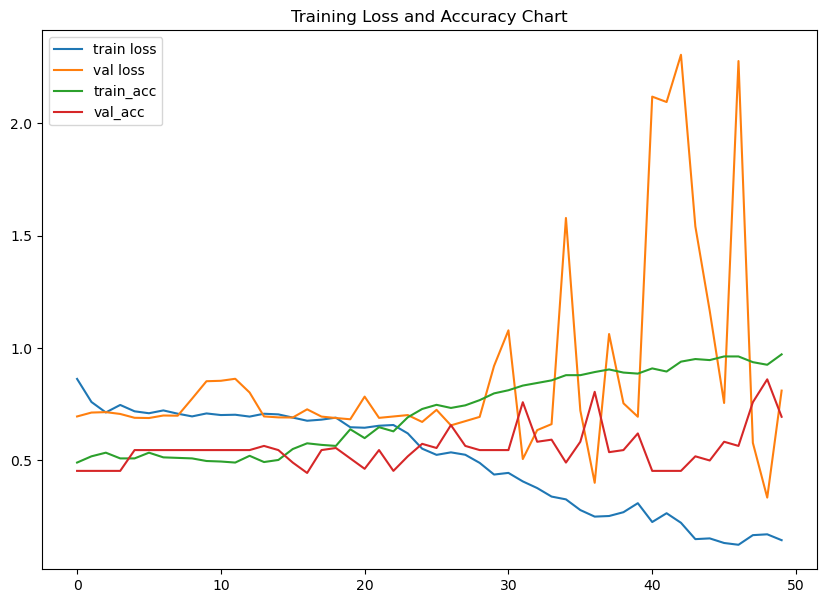

<Figure size 640x480 with 0 Axes>

In [85]:
plt.figure(figsize=(10,7))
plt.plot(progress.history['loss'], label='train loss')
plt.plot(progress.history['val_loss'], label='val loss')
plt.plot(progress.history['accuracy'], label='train_acc')
plt.plot(progress.history['val_accuracy'], label='val_acc')
plt.title("Training Loss and Accuracy Chart")
plt.legend()
plt.show()
plt.savefig('lossval_loss')

In [86]:
from tensorflow.keras.models import load_model
model.save('cnn_sign_model.hdf5')

In [88]:
cur_model = load_model('./cnn_sign_model.hdf5')
from tensorflow.keras.preprocessing import image

img = image.load_img('./DataSet/Dataset_Signature_Final/Dataset/dataset4/forge/00303002.png', target_size=(224,224))
x = image.img_to_array(img)
x


array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 2

In [89]:
x = x/255
from tensorflow.keras.applications.resnet50 import preprocess_input
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [90]:
cur_model.predict(img_data)

1/1 [==============================] - 0s 189ms/step


array([[1., 0.]], dtype=float32)

In [91]:
a=np.argmax(cur_model.predict(img_data), axis=1)
if(a==1):
    print("The signature is fraud")
else:
    print("The signature is not fraud")

1/1 [==============================] - 0s 20ms/step
The signature is not fraud


In [94]:
'''
real_img = cv2.imread('/content/drive/MyDrive/ML-Datasets-colab/Dataset_sign/dataset4/real1/02404024.png')
real_img = cv2.cvtColor(real_img,cv2.COLOR_BGR2RGB)
real_img = cv2.resize(real_img,IMAGE_SHAPE)
'''
real_img = Image.open('./DataSet/Dataset_Signature_Final/Dataset/dataset4/real1/02404024.png')
real_img = real_img.convert('RGB')
# Resize the image
real_img = real_img.resize(IMAGE_SHAPE)
real_img_array = np.array(real_img)

# Convert to float32
real_img_array = real_img_array.astype('float32')

# Normalize the image
real_img_array /= 255.0  # This is equivalent to real_img_array = real_img_array / 255.0

# Reshape the image for prediction
real_img_array = real_img_array.reshape((1, 224, 224, 3))

# Now, real_img_array is ready for prediction with your model
predcur = cur_model.predict(real_img_array)

1/1 [==============================] - 0s 32ms/step


In [96]:
a=np.argmax(model.predict(real_img_array), axis=1)
if(a==1):
    print("The signature is fraud")
else:
    print("The signature is not fraud")

1/1 [==============================] - 0s 14ms/step
The signature is not fraud


6/6 [==============================] - 1s 92ms/step


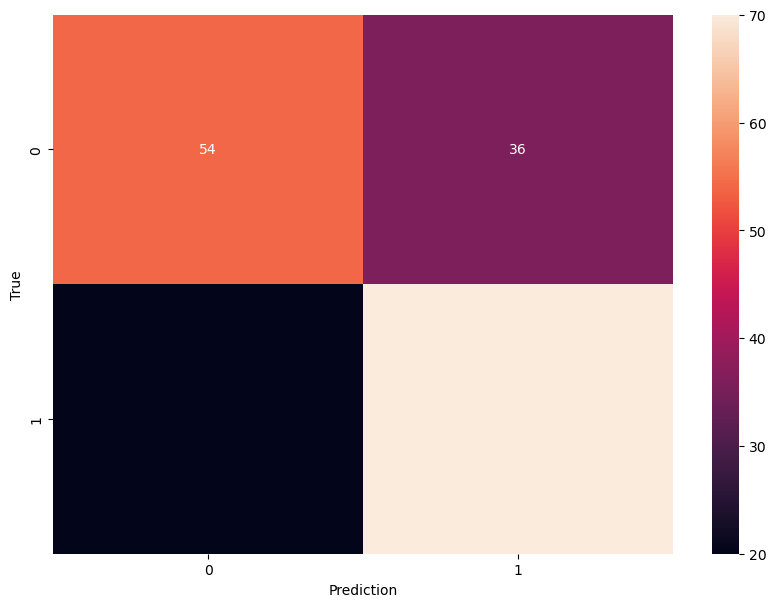

In [99]:
y_predictions =model.predict(testing_data)
y_predictions = [np.argmax(i) for i in y_predictions]
y_actual = [np.argmax(i) for i in testing_labels]
cm = confusion_matrix(y_actual,y_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.show()

In [100]:
print(classification_report(y_actual,y_predictions))

              precision    recall  f1-score   support

           0       0.73      0.60      0.66        90
           1       0.66      0.78      0.71        90

    accuracy                           0.69       180
   macro avg       0.70      0.69      0.69       180
weighted avg       0.70      0.69      0.69       180



In [101]:
forge_img =cv2.imread('/content/drive/MyDrive/ML-Datasets-colab/Dataset_sign/dataset4/forge/00304035.png')
forge_img = cv2.cvtColor(forge_img,cv2.COLOR_BGR2RGB)
forge_img = cv2.resize(forge_img,IMAGE_SHAPE)
forge_img=forge_img/255
forge_img = forge_img.reshape((1, 224, 224, 3))
predcur=model.predict(forge_img)

NameError: name 'cv2' is not defined

In [252]:
a=np.argmax(model.predict(forge_img), axis=1)
if(a==1):
    print("The signature is fraud")
else:
    print("The signature is not fraud")

1/1 [==============================] - 0s 22ms/step
The signature is fraud
